# MD PCA Analysis Tomás Frazão

**Last update: 27th Feb 2023**


More detailed PCA analysis are performed in this notebook. 


NOTE: you do not need to load an aligned trajectory as this will be done here.
IMPORTANT: Update SELECTIONS of atoms for fittings according to your system


### How to use this notebook


1. You have to run the cell containing the dependencies imports before starting to run the code. An easy way to have all_loop these dependencies install_looped is to create a conda environment with:

`conda create -n md_analysis -c anaconda -c conda-forge -c ambermd jupyter pytraj mdtraj matplotlib scikit-learn`


### Dependencies of this notebook
* matplotlib (-c conda-forge)
* pytraj (-c ambermd)
* scikit-learn (-c anaconda)
* mdtraj

In [1]:
%matplotlib inline
import pytraj as pt
import numpy as np
import math
import matplotlib.pyplot as plt
# we will also use mdtraj
import mdtraj as md
from mdtraj.testing import get_fn
#
from sklearn.decomposition import PCA
import time

import matplotlib.font_manager 
from matplotlib import rc

In [2]:
from matplotlib import font_manager

font_dirs = ['/home/tomas/Downloads']
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

# set font
plt.rcParams['font.family'] = 'Arial'

In [3]:
from IPython.core.display import HTML

def make_html(fontname):
    return "<p>{font}: <span style='font-family:{font}; font-size: 24px;'>{font}</p>".format(font=fontname)

code = "\n".join([make_html(font) for font in sorted(set([f.name for f in matplotlib.font_manager.fontManager.ttflist]))])

HTML("<div style='column-count: 2;'>{}</div>".format(code))

## 0. Selection of atoms object of study
Before starting the convergence analyses, the first thing is to define which part of the system will be object of study. 

Typically, very flexible parts such as terminal residues are avoided, and representative atoms of the backbone like alpha carbons are selected.

#### 0.1 Load the trajectory and topology files
Different possibilities are given (some commented) depending on the format of the trajectory files.
Possibilities if the MDs are loaded with pytraj:(basically amber formats)

http://amber-md.github.io/pytraj/latest/read_and_write.html

If the MDs are loaded with mdtraj, we have more possibilities, including xtc (gromacs) +pdb for topology, or a pdb traj.
http://mdtraj.org/1.6.2/load_functions.html#the-trajectory-object

We indicate also the length of the trajectory in ns only for correct axis labels in plots.

In [4]:
TRAJECTORY_I = 'I_both/I_traj.dcd'
TOPOLOGY_I = 'I_both/sys-fad-nowat.prmtop'

TRAJECTORY_II = 'II_both/II_traj.dcd'  
TOPOLOGY_II = 'II_both/AsP2Ox-Closed-C2_autoprep_validated_mini_nowat.prmtop'

TRAJECTORY_IV = 'IV_both/IV_traj.dcd' #it's actually system III without glucose (open glc)
TOPOLOGY_IV = 'IV_both/sys-minus-glc-fad-nowat.prmtop'


TRAJECTORY_LENGTH = 600 #Length of the trajectory in ns (for correct axis labels in plots)

In [5]:
traj_I = pt.iterload(TRAJECTORY_I, TOPOLOGY_I,frame_slice=(0, 62500,5))
#traj_I = traj_I[:]

In [6]:
traj_II = pt.iterload(TRAJECTORY_II, TOPOLOGY_II, frame_slice=(0, 125200, 10))
#traj_II = traj_II[:]

In [7]:
traj_IV = pt.iterload(TRAJECTORY_IV, TOPOLOGY_IV, frame_slice=(0, 62500, 5))
#traj_IV = traj_IV[:]

In [8]:
print(traj_I)
print(traj_II)
print(traj_IV)

pytraj.TrajectoryIterator, 12500 frames: 
Size: 2.116431 (GB)
<Topology: 7575 atoms, 508 residues, 2 mols, PBC with box type = ortho>
           
pytraj.TrajectoryIterator, 12520 frames: 
Size: 2.126533 (GB)
<Topology: 7599 atoms, 510 residues, 3 mols, PBC with box type = ortho>
           
pytraj.TrajectoryIterator, 12500 frames: 
Size: 2.108607 (GB)
<Topology: 7547 atoms, 506 residues, 2 mols, PBC with box type = ortho>
           


#### 0.2 Select the atoms that will be object of the study and align core
We use the notation of pytraj to select the atoms:

https://amber-md.github.io/pytraj/latest/atom_mask_selection.html


In [9]:
# This can be used for initial fitting. Corresponds to core except flexible loop and terminal of MCoA
#ref_SELECTION = '!(:1-6)&!(:285-313)&(@CA)'
ref_SELECTION = ":5-509@CA"

# This corresponds to all Ca (including loop) except flexible terminal. Used for RMSD.
SELECTION = ':5-509@CA'


Now the initial tajectory will be aligned. So no need to load aligned trajectory. 

In [10]:
trajectory_I = pt.align(traj_I, ref=0, ref_mask=ref_SELECTION, mass=False, top=None, frame_indices=None)
trajectory_II = pt.align(traj_II, ref=0, ref_mask=ref_SELECTION, mass=False, top=None, frame_indices=None)
trajectory_IV = pt.align(traj_IV, ref=0, ref_mask=ref_SELECTION, mass=False, top=None, frame_indices=None)

## 1.1. Substrate-loop (A352-CA) to N5 distance

In [11]:
# compute distance between S347-C and N5
Sloop_I = pt.distance(trajectory_I, ':348@CA :FAD@N5') #7537 (N5 on pdb) gives the right plot. This was check on vmd!! (FAD@N5 was used for consistency)
Sloop_II = pt.distance(trajectory_II, ':348@CA :FAD@N5') #7537 (N5 on pdb) gives the right plot. This was check on vmd!! (FAD@N5 was used for consistency)
Sloop_IV = pt.distance(trajectory_IV, ':348@CA :FAD@N5') #7522 (N5 on pdb) doesn´t give the right plot. This was check on vmd!!

#The N5 problem might have something to to with the fact that the FAD chain in the pdb file
#is diferent in II and IV (A12001; F in I and II). Tried to change it but the xtc file might also have been afected 

print(Sloop_I)
print(Sloop_II)
print(Sloop_IV)

[18.43390957 18.05410707 18.68714547 ... 19.24258108 18.51552931
 19.50578615]
[18.36386597 18.26994855 18.43774583 ... 23.87306327 24.22744123
 24.47232968]
[25.29587278 25.36428313 25.36746126 ... 16.99089523 16.96137444
 16.98999619]


In [12]:
MAX_DISTANCE_LOOP = math.ceil(Sloop_I.max()) #It can be modified if you want to change the scale of the plot. If xtc.
MIN_DISTANCE_LOOP = math.ceil(Sloop_I.min()) #For use in PCA plot. If xtc, as before.

## 1.2. Insertion (G84-CA) to N5 distance

In [13]:
# compute distance between P83-CG and N5
Iloop_I = pt.distance(trajectory_I, ':80@CA :FAD@N5') #7537 (N5 on pdb) gives the right plot. This was check on vmd!! (FAD@N5 was used for consistency)
Iloop_II = pt.distance(trajectory_II, ':80@CA :FAD@N5') #7537 (N5 on pdb) gives the right plot. This was check on vmd!! (FAD@N5 was used for consistency)
Iloop_IV = pt.distance(trajectory_IV, ':80@CA :FAD@N5') #7522 (N5 on pdb) doesn´t give the right plot. This was check on vmd!!



print(Iloop_I)
print(Iloop_II)
print(Iloop_IV)

[19.65730511 20.49190101 20.50236304 ... 20.41423011 21.11460468
 20.62087842]
[18.33611131 18.03335676 18.52164562 ... 18.63381604 19.09123442
 19.1900119 ]
[30.98495072 30.01076096 29.8824819  ... 20.75381563 19.76844829
 20.03398139]


In [14]:

MAX_DISTANCE_INSERTION = math.ceil(Iloop_I.max()) #It can be modified if you want to change the scale of the plot. If xtc.
MIN_DISTANCE_INSERTION = math.ceil(Iloop_I.min()) #For use in PCA plot. If xtc, as before.


# 2. PCA analysis with distance loop-FAD N5

## 2.1. NATIVE

In [15]:
#step_PCA = math.ceil(float(len(trajectory)/3334)) # Step size: trajectory frames that will be used in the analysis (e.g. if step is 20, frames 0, 20, 40 ... will be selected)
#traj_PCA = trajectory[::step_PCA]
traj_PCA1 = traj_I
data = pt.pca(traj_PCA1, mask=SELECTION, n_vecs=2) #If no ref is given, fits to average structure
projection_data = data[0]

In [16]:
PCA1_FILENAME = './PCA_subLoop_I.png' #Output filename for the plot

MIN_X_VALUE = math.floor(projection_data[0].min(axis=0)) #It can be modified if you want to force the scale of the plot
MAX_X_VALUE = math.ceil(projection_data[0].max(axis=0)) #It can be modified if you want to force the scale of the plot
MIN_Y_VALUE = math.floor(projection_data[1].min(axis=0)) #It can be modified if you want to force the scale of the plot
MAX_Y_VALUE = math.ceil(projection_data[1].max(axis=0)) #It can be modified if you want to force the scale of the plot
POINTS_SIZE = 60 #You can adjust the size of the points of the plot

MAX_DISTANCE_LOOP_I = math.ceil(Sloop_I.max())
MIN_DISTANCE_LOOP_I = math.ceil(Sloop_I.min()) 

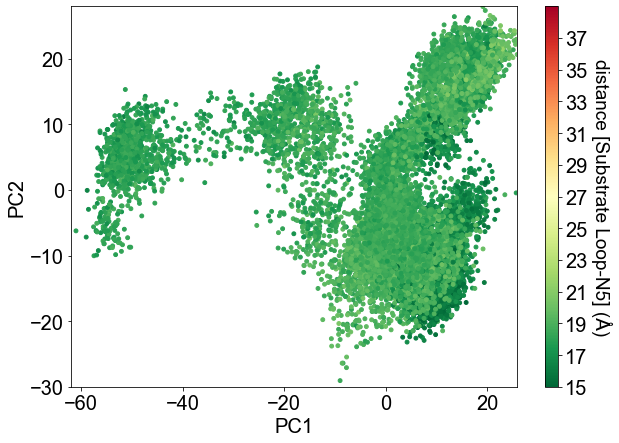

In [17]:
plt.rcParams['font.size']=20
plt.figure(figsize=(10,7))
plt.scatter(projection_data[0], projection_data[1], marker='.', c=Sloop_I, 
            vmin=15, vmax=39, s=POINTS_SIZE, cmap='RdYlGn_r')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.xlim([MIN_X_VALUE, MAX_X_VALUE])
plt.ylim([MIN_Y_VALUE, MAX_Y_VALUE])
cbar = plt.colorbar(aspect=30)
ticks = np.arange(int(15), int(39), 2)
cbar.set_ticks(ticks)
cbar.ax.tick_params()
cbar.set_label('distance [Substrate Loop-N5] (Å)', rotation=-90, va="bottom", fontsize=19)
plt.savefig(PCA1_FILENAME, bbox_inches='tight', dpi=600)

## 2.2. SEMI-OPEN WITH GLUCOSE

In [18]:
#step_PCA = math.ceil(float(len(trajectory)/3334)) # Step size: trajectory frames that will be used in the analysis (e.g. if step is 20, frames 0, 20, 40 ... will be selected)
#traj_PCA = trajectory[::step_PCA]
traj_PCA2 = traj_II
data2 = pt.pca(traj_PCA2, mask=SELECTION, n_vecs=2) #If no ref is given, fits to average structure
projection_data2 = data2[0]

In [19]:
PCA2_FILENAME = './PCA_subLoop_II.png' #Output filename for the plot

MIN_X_VALUE2 = math.floor(projection_data2[0].min(axis=0)) #It can be modified if you want to force the scale of the plot
MAX_X_VALUE2 = math.ceil(projection_data2[0].max(axis=0)) #It can be modified if you want to force the scale of the plot
MIN_Y_VALUE2 = math.floor(projection_data2[1].min(axis=0)) #It can be modified if you want to force the scale of the plot
MAX_Y_VALUE2 = math.ceil(projection_data2[1].max(axis=0)) #It can be modified if you want to force the scale of the plot
POINTS_SIZE = 60 #You can adjust the size of the points of the plot

MAX_DISTANCE_LOOP_II = math.ceil(Sloop_II.max())
MIN_DISTANCE_LOOP_II = math.ceil(Sloop_II.min()) 

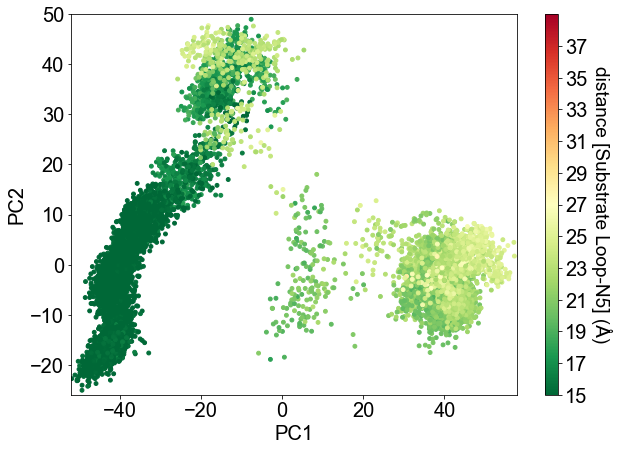

In [20]:
plt.rcParams['font.size']=20
plt.figure(figsize=(10,7))
plt.scatter(projection_data2[0], projection_data2[1], marker='.', c=Sloop_II, 
            vmin=15, vmax=39, s=POINTS_SIZE, cmap='RdYlGn_r')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.xlim([MIN_X_VALUE2, MAX_X_VALUE2])
plt.ylim([MIN_Y_VALUE2, MAX_Y_VALUE2])
cbar = plt.colorbar(aspect=30)
ticks = np.arange(int(15), int(39), 2)
cbar.set_ticks(ticks)
cbar.ax.tick_params()
cbar.set_label('distance [Substrate Loop-N5] (Å)', rotation=-90, va="bottom", fontsize=19)
plt.savefig(PCA2_FILENAME, bbox_inches='tight', dpi=600)

## 2.3. OPEN WITHOUT GLUCOSE

In [21]:
#step_PCA = math.ceil(float(len(trajectory)/3334)) # Step size: trajectory frames that will be used in the analysis (e.g. if step is 20, frames 0, 20, 40 ... will be selected)
#traj_PCA = trajectory[::step_PCA]
traj_PCA3 = traj_IV
data3 = pt.pca(traj_PCA3, mask=SELECTION, n_vecs=2) #If no ref is given, fits to average structure
projection_data3 = data3[0]

In [22]:
PCA3_FILENAME = './PCA_subLoop_IV.png' #Output filename for the plot

MIN_X_VALUE3 = math.floor(projection_data3[0].min(axis=0)) #It can be modified if you want to force the scale of the plot
MAX_X_VALUE3 = math.ceil(projection_data3[0].max(axis=0)) #It can be modified if you want to force the scale of the plot
MIN_Y_VALUE3 = math.floor(projection_data3[1].min(axis=0)) #It can be modified if you want to force the scale of the plot
MAX_Y_VALUE3 = math.ceil(projection_data3[1].max(axis=0)) #It can be modified if you want to force the scale of the plot
POINTS_SIZE = 60 #You can adjust the size of the points of the plot

MAX_DISTANCE_LOOP_IV = math.ceil(Sloop_IV.max())
MIN_DISTANCE_LOOP_IV = math.ceil(Sloop_IV.min()) 

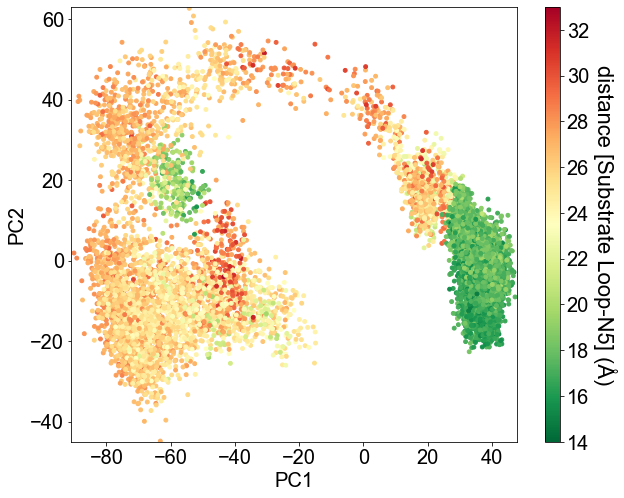

In [23]:
plt.rcParams['font.size']=20
plt.figure(figsize=(10,8))
plt.scatter(projection_data3[0], projection_data3[1], marker='.', c=Sloop_IV, 
            vmin=MIN_DISTANCE_LOOP_IV, vmax=MAX_DISTANCE_LOOP_IV, s=POINTS_SIZE, cmap='RdYlGn_r')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.xlim([MIN_X_VALUE3, MAX_X_VALUE3])
plt.ylim([MIN_Y_VALUE3, MAX_Y_VALUE3])
cbar = plt.colorbar(aspect=30)
ticks = np.arange(int(MIN_DISTANCE_LOOP_IV), int(MAX_DISTANCE_LOOP_IV), 2)
cbar.set_ticks(ticks)
cbar.ax.tick_params()
cbar.set_label('distance [Substrate Loop-N5] (Å)', rotation=-90, va="bottom", fontsize=22)
plt.savefig(PCA3_FILENAME, bbox_inches='tight', dpi=600)

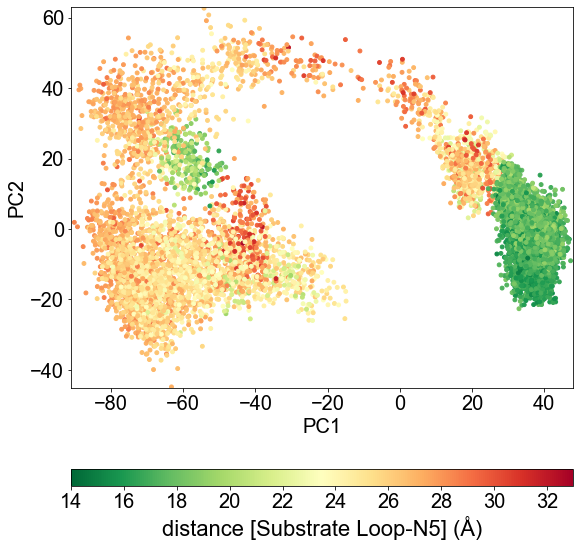

In [24]:
plt.rcParams['font.size']=20
plt.figure(figsize=(9,10))
plt.scatter(projection_data3[0], projection_data3[1], marker='.', c=Sloop_IV, 
            vmin=MIN_DISTANCE_LOOP_IV, vmax=MAX_DISTANCE_LOOP_IV, s=POINTS_SIZE, cmap='RdYlGn_r')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.xlim([MIN_X_VALUE3, MAX_X_VALUE3])
plt.ylim([MIN_Y_VALUE3, MAX_Y_VALUE3])
cbar = plt.colorbar(aspect=30, orientation='horizontal')
ticks = np.arange(int(MIN_DISTANCE_LOOP_IV), int(MAX_DISTANCE_LOOP_IV), 2)
cbar.set_ticks(ticks)
cbar.ax.tick_params()
cbar.set_label('distance [Substrate Loop-N5] (Å)', rotation=0, va="top", fontsize=22)
plt.savefig('./3PCA_subLoop_IV.png', bbox_inches='tight', dpi=600)

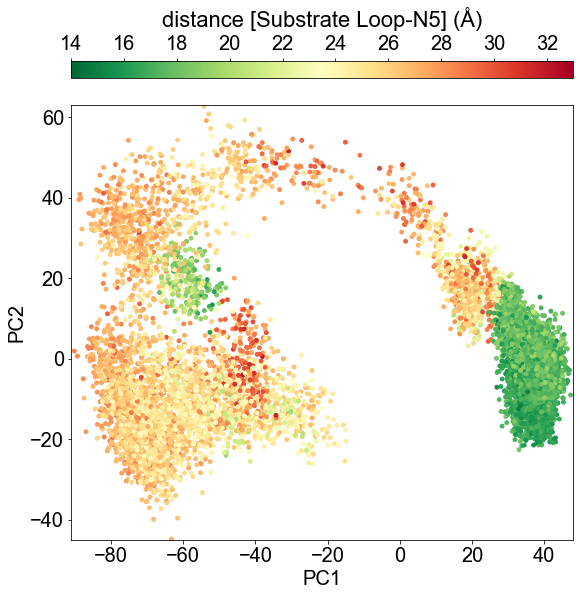

In [25]:
plt.rcParams['font.size']=20
plt.figure(figsize=(9,10))
plt.scatter(projection_data3[0], projection_data3[1], marker='.', c=Sloop_IV, 
            vmin=MIN_DISTANCE_LOOP_IV, vmax=MAX_DISTANCE_LOOP_IV, s=POINTS_SIZE, cmap='RdYlGn_r')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.xlim([MIN_X_VALUE3, MAX_X_VALUE3])
plt.ylim([MIN_Y_VALUE3, MAX_Y_VALUE3])
cbar = plt.colorbar(aspect=30, orientation='horizontal', location='top')
ticks = np.arange(int(MIN_DISTANCE_LOOP_IV), int(MAX_DISTANCE_LOOP_IV), 2)
cbar.set_ticks(ticks)
cbar.ax.tick_params()
cbar.set_label('distance [Substrate Loop-N5] (Å)', rotation=0, va="bottom", fontsize=22)
plt.savefig('./2PCA_subLoop_IV.png', bbox_inches='tight', dpi=600)

# 3. PCA analysis with distance insertion-FAD N5

## 3.1. NATIVE

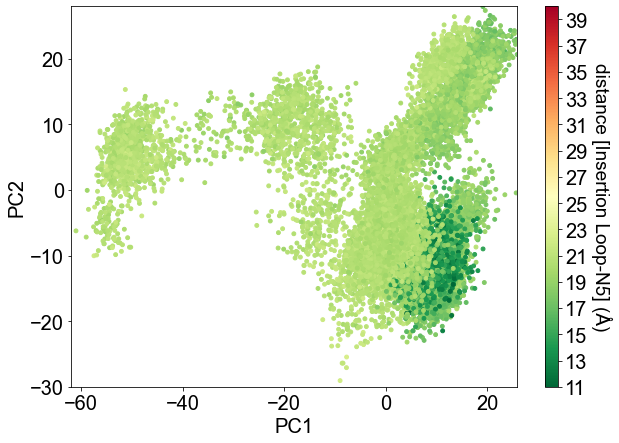

In [26]:
plt.rcParams['font.size']=20
plt.figure(figsize=(10,7))
plt.scatter(projection_data[0], projection_data[1], marker='.', c=Iloop_I, 
            vmin=11, vmax=40, s=POINTS_SIZE, cmap='RdYlGn_r')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.xlim([MIN_X_VALUE, MAX_X_VALUE])
plt.ylim([MIN_Y_VALUE, MAX_Y_VALUE])
cbar = plt.colorbar(aspect=30)
ticks = np.arange(int(11), int(40), 2)
cbar.set_ticks(ticks)
cbar.ax.tick_params()
cbar.set_label('distance [Insertion Loop-N5] (Å)', rotation=-90, va="bottom", fontsize=19)
plt.savefig('./PCA_Ins_I.png', bbox_inches='tight', dpi=600)

## 3.2. SEMI-OPEN WITH GLUCOSE

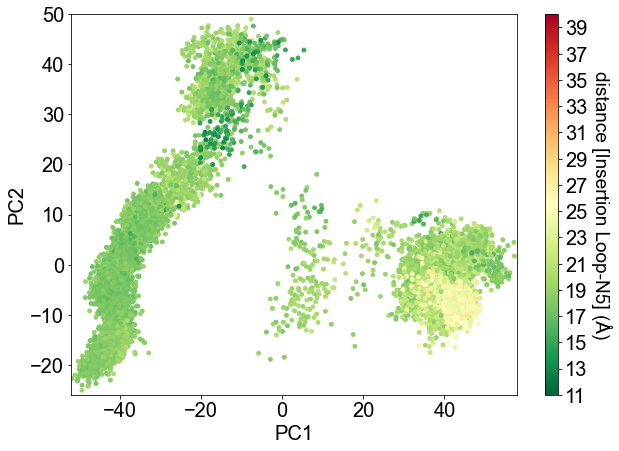

In [27]:
plt.rcParams['font.size']=20
plt.figure(figsize=(10,7))
plt.scatter(projection_data2[0], projection_data2[1], marker='.', c=Iloop_II, 
            vmin=11, vmax=40, s=POINTS_SIZE, cmap='RdYlGn_r')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.xlim([MIN_X_VALUE2, MAX_X_VALUE2])
plt.ylim([MIN_Y_VALUE2, MAX_Y_VALUE2])
cbar = plt.colorbar(aspect=30)
ticks = np.arange(int(11), int(40), 2)
cbar.set_ticks(ticks)
cbar.ax.tick_params()
cbar.set_label('distance [Insertion Loop-N5] (Å)', rotation=-90, va="bottom", fontsize=19)
plt.savefig('./PCA_Ins_II.png', bbox_inches='tight', dpi=600)

## 3.3. OPEN WITHOUT GLUCOSE

In [33]:
INS_PCA3_FILENAME = './PCA_Ins_IV.png' #Output filename for the plot

MIN_X_VALUE3 = math.floor(projection_data3[0].min(axis=0)) #It can be modified if you want to force the scale of the plot
MAX_X_VALUE3 = math.ceil(projection_data3[0].max(axis=0)) #It can be modified if you want to force the scale of the plot
MIN_Y_VALUE3 = math.floor(projection_data3[1].min(axis=0)) #It can be modified if you want to force the scale of the plot
MAX_Y_VALUE3 = math.ceil(projection_data3[1].max(axis=0)) #It can be modified if you want to force the scale of the plot
POINTS_SIZE = 60 #You can adjust the size of the points of the plot

MAX_DISTANCE_INS_IV = math.ceil(Iloop_IV.max())
MIN_DISTANCE_INS_IV = math.ceil(Iloop_IV.min()) 

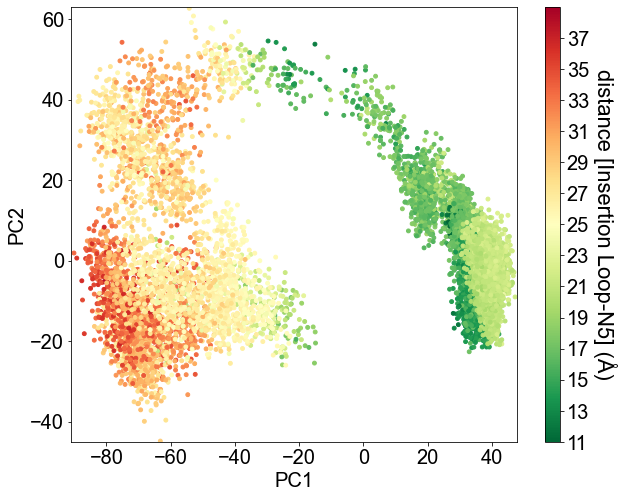

In [34]:
plt.rcParams['font.size']=20
plt.figure(figsize=(10,8))
plt.scatter(projection_data3[0], projection_data3[1], marker='.', c=Iloop_IV, 
            vmin=MIN_DISTANCE_INS_IV, vmax=MAX_DISTANCE_INS_IV, s=POINTS_SIZE, cmap='RdYlGn_r')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.xlim([MIN_X_VALUE3, MAX_X_VALUE3])
plt.ylim([MIN_Y_VALUE3, MAX_Y_VALUE3])
cbar = plt.colorbar(aspect=30)
ticks = np.arange(int(MIN_DISTANCE_INS_IV), int(MAX_DISTANCE_INS_IV), 2)
cbar.set_ticks(ticks)
cbar.ax.tick_params()
cbar.set_label('distance [Insertion Loop-N5] (Å)', rotation=-90, va="bottom", fontsize=22)
plt.savefig(INS_PCA3_FILENAME, bbox_inches='tight', dpi=600)

# 4. PCA analysis with time

## 4.1. NATIVE

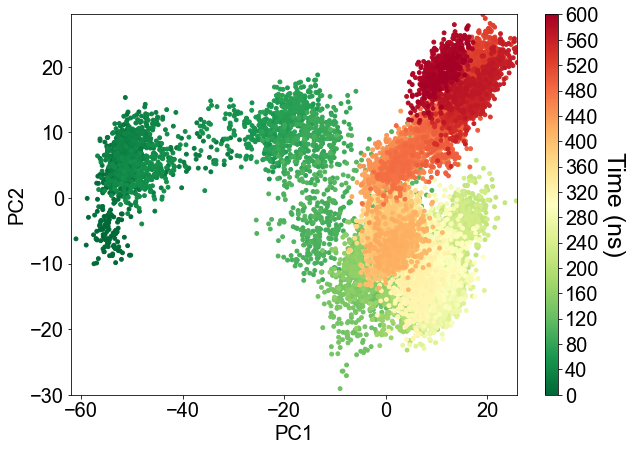

In [30]:
plt.rcParams['font.size']=20
plt.figure(figsize=(10,7))
plt.scatter(projection_data[0], projection_data[1], marker='.', c=range(len(traj_PCA1)), 
            vmin=0, vmax=len(traj_PCA1), s=POINTS_SIZE, cmap='RdYlGn_r')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.xlim([MIN_X_VALUE, MAX_X_VALUE])
plt.ylim([MIN_Y_VALUE, MAX_Y_VALUE])
cbar = plt.colorbar(aspect=30)
ticks = np.arange(0, len(traj_PCA1), len(traj_PCA1)//15)
cbar.set_ticks(ticks)
cbar.ax.tick_params()
cbar.set_ticklabels([math.ceil(a*TRAJECTORY_LENGTH/len(traj_PCA1)) for a in ticks])
cbar.set_label('Time (ns)', rotation=-90, va="bottom", fontsize=25)
plt.savefig('./PCA_TIME_I.png', bbox_inches='tight', dpi=600)

# 4.2. SEMI-OPEN WITH GLUCOSE

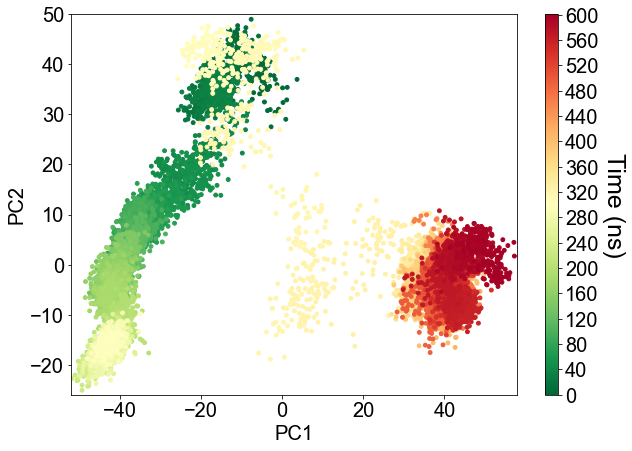

In [31]:
plt.rcParams['font.size']=20
plt.figure(figsize=(10,7))
plt.scatter(projection_data2[0], projection_data2[1], marker='.', c=range(len(traj_PCA2)), 
            vmin=0, vmax=len(traj_PCA2), s=POINTS_SIZE, cmap='RdYlGn_r')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.xlim([MIN_X_VALUE2, MAX_X_VALUE2])
plt.ylim([MIN_Y_VALUE2, MAX_Y_VALUE2])
cbar = plt.colorbar(aspect=30)
ticks = np.arange(0, len(traj_PCA2), len(traj_PCA2)//15)
cbar.set_ticks(ticks)
cbar.ax.tick_params()
cbar.set_ticklabels([math.ceil(a*TRAJECTORY_LENGTH/len(traj_PCA2)) for a in ticks])
cbar.set_label('Time (ns)', rotation=-90, va="bottom", fontsize=25)
plt.savefig('./PCA_TIME_II.png', bbox_inches='tight', dpi=600)

## 4.3. OPEN WITHOUT GLUCOSE

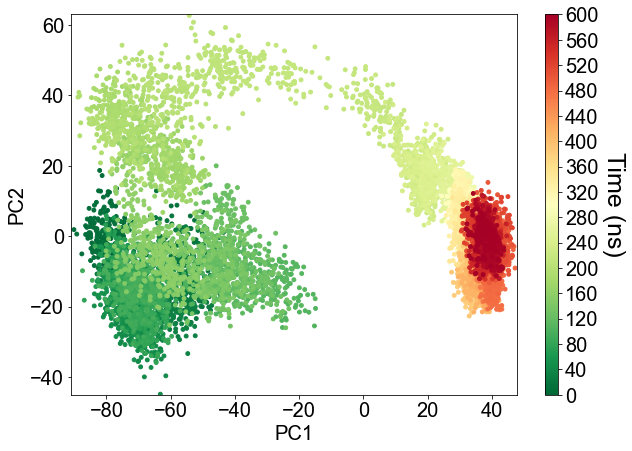

In [32]:
plt.rcParams['font.size']=20
plt.figure(figsize=(10,7))
plt.scatter(projection_data3[0], projection_data3[1], marker='.', c=range(len(traj_PCA3)), 
            vmin=0, vmax=len(traj_PCA3), s=POINTS_SIZE, cmap='RdYlGn_r')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.xlim([MIN_X_VALUE3, MAX_X_VALUE3])
plt.ylim([MIN_Y_VALUE3, MAX_Y_VALUE3])
cbar = plt.colorbar(aspect=30)
ticks = np.arange(0, len(traj_PCA3), len(traj_PCA3)//15)
cbar.set_ticks(ticks)
cbar.ax.tick_params()
cbar.set_ticklabels([math.ceil(a*TRAJECTORY_LENGTH/len(traj_PCA3)) for a in ticks])
cbar.set_label('Time (ns)', rotation=-90, va="bottom", fontsize=25)
plt.savefig('./PCA_TIME_IV.png', bbox_inches='tight', dpi=600)